In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

import sys
import os
from pathlib import Path
import pickle
import numpy as np
import time
import sklearn.model_selection as model_selection
from sklearn.decomposition import PCA
main_folder=str(Path.cwd().parent) 
sys.path.append(main_folder) 
data_folder = f'{main_folder}/data'


# TO-DO:

- Improve the accuracy via Feature Engineer or Hyperparam
- Try with 3 classes (STAR, GALAXY , QSOR)
- Try with more data (currently training is 100 and test is 40 and test extra is 20)

## Loading the processed data DR16_Processed

In [120]:
#Load the data from pickle file

with open(f'{data_folder}/processed/DR16_processed_X.pkl','rb') as input_file:
    X = pickle.load(input_file)
with open(f'{data_folder}/processed/DR16_processed_y.pkl','rb') as input_file:
    y = pickle.load(input_file)

# You can also load the csv file but bewared of the datatype   
# X = pd.read_csv(f'{data_folder}/processed/DR16_processed_X.csv')
# y = pd.read_csv(f'{data_folder}/processed/DR16_processed_y.csv')

In [9]:
print(len(X))
print(len(y))

100000
100000


In [121]:
# Create binary target for 1st trial
y_star = y.apply(lambda x: "STAR" if x == "STAR" else "NOT_STAR")
class_labels_Star = list(set(y_star))
y_star_num =  y_star.apply(lambda x: 1 if x == "STAR" else 0)

In [131]:
#Create training_dataset and test_dataset with STAR and NOT_STAR
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_star_num, train_size=0.001, test_size=0.99, random_state=101)

# Create 1st test data
X_test_40 = X_test.iloc[:40].copy()
y_test_40 = y_test.iloc[:40].copy()

# 2nd test data 
X_test_extra = X_test.iloc[41:60].copy()
y_test_extra = y_test.iloc[41:60].copy()

print(X_train.shape)
print(X_test_40.shape)
print(X_test_extra.shape)

(100, 8)
(40, 8)
(19, 8)


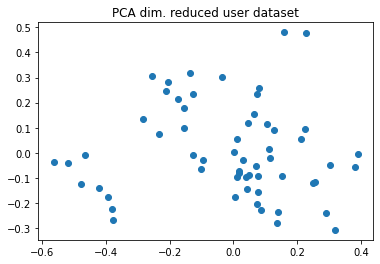

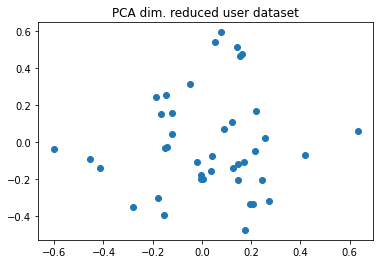

In [132]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test_40 = pca.transform(X_test_40)
X_test_extra = pca.transform(X_test_extra)

# Create datapoint[X_test,y]
datapoints = [np.array(X_test_extra),np.array(y_test_extra)]
# If class labels are numeric
training_size = len(X_train)
test_size = len(X_test_40)
test_size_extra = len(X_test_extra)

#this is where I transform our dataframe to Dict[key:np.array]
if class_labels_Star[0].isdigit():
        # Pick training size number of samples from each distro
    training_input = {key: (X_train[y_train == int(key), :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == int(key), :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test == int(key), :])[: test_size] for k, key in enumerate(class_labels_Star)}
else:
    # if they aren't
    training_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == k, :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test_40 == k, :])[:test_size] for k, key in enumerate(class_labels_Star)}

# Plot the 2 dimension result of PCA to check for correlation 
for k in range(0, 2):
    plt.scatter(X_train[y_train == k, 0][:training_size],
    X_train[y_train == k, 1][:training_size])
       
    plt.title("PCA dim. reduced user dataset")
    plt.show()   

With the dataset ready we can setup the [QSVM](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm to do a classification. Here we use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

For the testing, the result includes the details and the success ratio. For the prediction, the result includes the predicted labels. 

 QSVM
 """
        Args:
            feature_map: Feature map module, used to transform data
            training_dataset: Training dataset.
            test_dataset: Testing dataset.
            datapoints: Prediction dataset.
            multiclass_extension: If number of classes is greater than 2 then a multiclass scheme
                must be supplied, in the form of a multiclass extension.
            lambda2: L2 norm regularization factor
            quantum_instance: Quantum Instance or Backend

In [133]:
print(len(training_input['STAR']))

59


In [135]:
feature_dim = 2

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
start_run_qsvm = time.time()
result = qsvm.run(quantum_instance)
end_run_qsvm = time.time()
print(f'run time is: {end_run_qsvm - start_run_qsvm}')

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

run time is: 46.28296256065369
Testing success ratio: 0.425

Prediction from datapoints set:
  ground truth: ['NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'NOT_STAR', 'STAR']
  prediction:   ['STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'STAR', 'NOT_STAR', 'STAR']
  success rate: 63.1578947368421%


Qiskit also has a classical SVM implementation that takes the same input data for classification. Let's run this and do a comparison. Now the ad hoc data set was created to show that there can be datasets where quantum could give an advantage.

## New

In [165]:
def split_balanced(data, target, train_size=100, test_size=60):
    
    np.random.seed(0)

    classes = np.unique(target)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = train_size #max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test

In [4]:
prep = ZZFeatureMap(2, reps=2)
print(prep)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


In [5]:
prep = ZZFeatureMap(2, reps=3)
print(prep)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           ┌───┐»
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
«     └──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ 

In [136]:
with open(f'{data_folder}/processed/DR16_processed_X.pkl','rb') as input_file:
    X = pickle.load(input_file)
with open(f'{data_folder}/processed/DR16_processed_y.pkl','rb') as input_file:
    y = pickle.load(input_file)


In [137]:
y.values

array(['STAR', 'STAR', 'STAR', ..., 'GALAXY', 'GALAXY', 'STAR'],
      dtype=object)

In [138]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_num = le.fit_transform(y.values)

In [139]:
set(y)

{'GALAXY', 'QSO', 'STAR'}

### Imbalanced Dataset

In [61]:
#Create training_dataset and test_dataset with STAR and NOT_STAR
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_num, train_size=0.001, test_size=0.0006, random_state=101, stratify=y_num)

X_val = X_test[0:40]
X_pred = X_test[40:60]
y_val = y_test[0:40]
y_pred = y_test[40:60]

print(X_train.shape)
print(X_val.shape)
print(X_pred.shape)


print(y_train.shape)
print(y_val.shape)
print(y_pred.shape)


(100, 8)
(40, 8)
(20, 8)
(100,)
(40,)
(20,)


In [58]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[ 0, 51],
       [ 1, 11],
       [ 2, 38]], dtype=int64)

### Balanced Dataset

In [167]:
X_train, X_test, y_train, y_test = split_balanced(np.array(X), y_num, train_size=100, test_size=60)

# X_val = X_test[0:40]
# X_pred = X_test[40:60]
# y_val = y_test[0:40]
# y_pred = y_test[40:60]

print(X_train.shape)
print(X_test.shape)
# print(X_pred.shape)


print(y_train.shape)
print(y_test.shape)
# print(y_pred.shape)


(99, 8)
(60, 8)
(99,)
(60,)


In [168]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(" Training data distribution\n", frequencies)

(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(" Test data distribution\n", frequencies)

 Training data distribution
 [[ 0 33]
 [ 1 33]
 [ 2 33]]
 Test data distribution
 [[ 0 20]
 [ 1 20]
 [ 2 20]]


In [142]:
class_labels = list(set(y))
class_labels

['STAR', 'QSO', 'GALAXY']

### Dimensionality Reduction

In [169]:
pca = PCA(n_components=3).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_pred = pca.transform(X_pred)

# Create datapoint[X_test,y]
datapoints = [np.array(X_test),np.array(y_test)]
# If class labels are numeric
training_size = len(X_train)
test_size = len(X_test)

#this is where I transform our dataframe to Dict[key:np.array]
if class_labels[0].isdigit():
        # Pick training size number of samples from each distro
    training_input = {key: (X_train[y_train == int(key), :])[:training_size] for k, key in enumerate(class_labels)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == int(key), :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test[y_test == int(key), :])[: test_size] for k, key in enumerate(class_labels)}
else:
    # if they aren't
    training_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == k, :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test[y_test == k, :])[:test_size] for k, key in enumerate(class_labels)}


In [170]:
import plotly.express as px

total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter(X_train, x=0, y=1, color=y_train)
fig.show()

93.6041527733398


In [171]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    X_train, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

### QSVM

In [173]:
from qiskit.aqua.components.multiclass_extensions import AllPairs

seed = 10598
feature_dim = 3

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='full')

qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension = AllPairs())

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.55


In [174]:
feature_dim = 3

feature_map =  PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z', 'ZZ'])
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension = AllPairs())

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.5


In [175]:
feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z', 'YY'])
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension = AllPairs())

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.4666666666666667


In [176]:
feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension = AllPairs())

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.5666666666666667


## Classical SVM

Three-class classification

In [177]:
from qiskit.aqua.algorithms import SklearnSVM

result = SklearnSVM(training_input, test_input, multiclass_extension = AllPairs()).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.5833333333333333


Two-class classification (STAR vs NOT STAR)

In [134]:
from qiskit.aqua.algorithms import SklearnSVM

result = SklearnSVM(training_input, test_input, multiclass_extension = AllPairs()).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')

Dataset has just two classes. Supplied multiclass extension will be ignored


Testing success ratio: 0.6
